# How the Climate in Tehran, Iran has Changed Over a Century

Last week, Iran has stand out with __[flooding in the news](https://www.aljazeera.com/news/2019/03/iran-flood-dozen-killed-flash-flooding-190326081204605.html)__. We can also read about the researches that say Middle East climate is changing fast and there will be more hot days and also flooding will occur more often. 

All these news made us curious and we decided to look into history using __[NASA MERRA2 dataset](https://data.planetos.com/datasets/nasa_merra2_global)__ at __[Planet OS Datahub](https://data.planetos.com)__. 


So, we will do the following:

1) use the Planet OS package API to fetch data;

2) see mean annual maximum temperature in Tehran

3) plot number of days in year when max temperature exceeds 30 $^o$C in Tehran;

4) find out annual precipitation by year;

4) find out how many dry days there has been;

5) find out what has going on during this year with precipitation;

6) see how many days have more than 10 mm precipitation during the years

7) we will see average annual precipitation cycle


__Note that this notebook is using Python 3.__

In [20]:
%matplotlib inline
import numpy as np
from dh_py_access import package_api
import dh_py_access.lib.datahub as datahub
import xarray as xr
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from mpl_toolkits.basemap import Basemap
from po_data_process import make_comparison_plot, make_plot, make_anomalies_plot,read_data_to_json,make_monthly_plot
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DayLocator, YearLocator
from matplotlib.ticker import MultipleLocator
import requests
import warnings
warnings.filterwarnings("ignore")

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [21]:
server = 'api.planetos.com'
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'
version = 'v1'

At first, we need to define the dataset name and variables we want to use. 

In [22]:
dh=datahub.datahub(server,version,API_key)
dataset='nasa_merra2_global'
variable_name_merra = 'TPRECMAX,T2MMEAN'
time_start = '1980-01-01T00:00:00'
time_end = datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%dT%H:%M:%S')
area_name = 'Tehran'
latitude = 35.68; longitude = 51.32

For starters, using Basemap we created a map of Africa and Middle East and marked the location of Tehran city. 

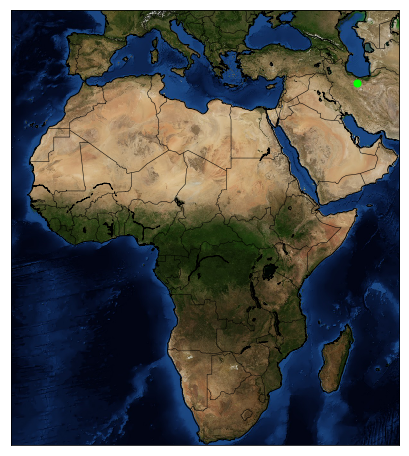

In [23]:
plt.figure(figsize=(10,8))
m = Basemap(projection='merc',llcrnrlat=-35,urcrnrlat=47.,\
            llcrnrlon=-21,urcrnrlon=60,lat_ts=0,resolution='l')
x,y = m(longitude,latitude)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()
m.scatter(x,y,50,marker='o',color='#00FF00',zorder=4)
plt.show()

##### Download the data with package API

1. Create package objects
2. Send commands for the package creation
3. Download the package files


In [24]:
package = package_api.package_api(dh,dataset,variable_name_merra,longitude,longitude,latitude,latitude,time_start,time_end,area_name=area_name)

In [25]:
package.make_package()

In [26]:
package.download_package()

## Work with downloaded files

We start by opening the files with xarray. We will do some conversion here as well, as it's easier to work with more commont units. For temperature we convert Kelvins to Celsius and for precipitation kg m-2 s-1 to mm/hour. 

In [27]:
dd1 = xr.open_dataset(package.local_file_name)
temp = dd1['T2MMEAN'] - 272.15
temp = temp.loc[temp['time.year']<2019]
prec = dd1['TPRECMAX'] = dd1['TPRECMAX'] * 3600 #convert to mm/hr

First, we evaluate temperature during the past 38 years by finding out overall average temperature in Teheran. We are also computing annual mean temperature data.

In [28]:
yearly_temp = temp.resample(time="1AS").mean('time')[:,0,0]
yearly_temp = yearly_temp.loc[yearly_temp['time.year'] < 2019] 
temp_mean = yearly_temp.mean(axis=0)
print ('Overall mean temperature is ' + str("%.2f" % temp_mean.values))\

Overall mean temperature is 17.44


Now it is time to plot mean annual mean temperature in Teheran. We also marked overall average for 1980-2018 17.4 °C with a red dotted line. The green line marks a trend. We can see a rising trend, however, last years haven't been the hottest in history. 2010 was the hottest year in the 38 year history with temperature 19.1 °C. For comparison, last year mean temperature was 18.8 °C. Also, which is worrying is that 2012 was the last year that had a temperature below long term average temperature. 

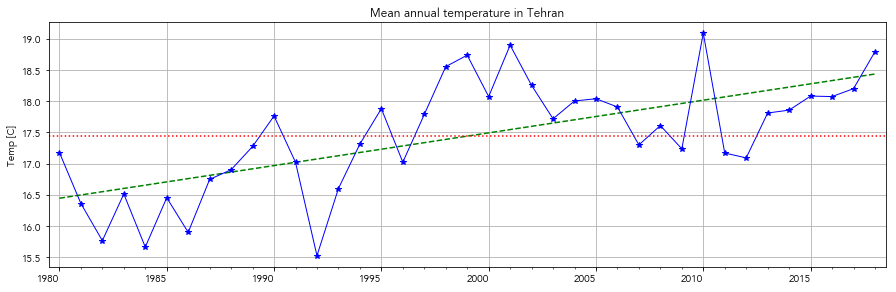

In [29]:
make_plot(yearly_temp,dataset,'Mean annual temperature in ' + area_name,ylabel = 'Temp [C]',compare_line = temp_mean.values,trend=True,locator = [5,1])

Number of days when temperature exceeds 30 C degrees has also rising trend. 

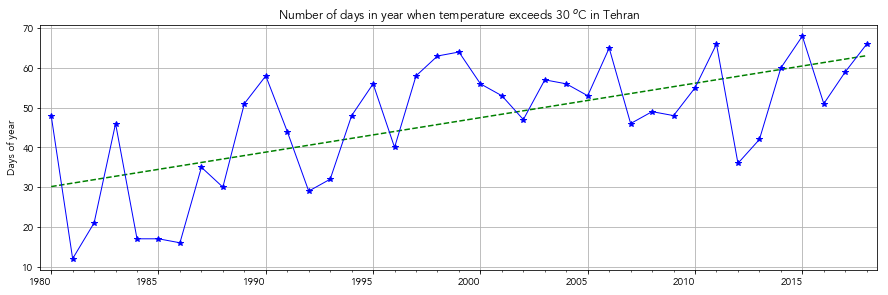

Yearly average days when temperature exceeds 30 C is 46.6


In [30]:
daily_data = temp.resample(time="1D").mean('time')[:,0,0]
make_plot(daily_data[np.where(daily_data.values > 30)].groupby('time.year').count(),dataset,'Number of days in year when temperature exceeds 30 $^o$C in ' + area_name,ylabel = 'Days of year',locator = [5,1],trend=True)
print ('Yearly average days when temperature exceeds 30 C is ' + str("%.1f" % daily_data[np.where(daily_data.values > 30)].groupby('time.year').count().mean().values))

Just as important as the change with the temperature is what has happened to the rainfall. To investigate that, we created an annual precipitation plot,  where a red line marks the average (84.1 mm). From the plot we can see that the average amount of rainfall has been inreasing a bit over the past century in Tehran. 

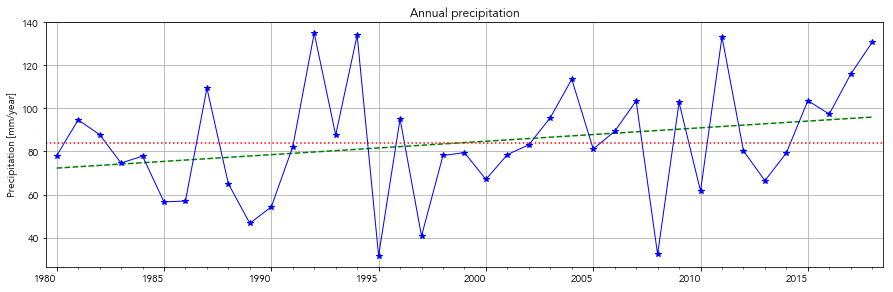

Average annual precipitation 84.1 mm


In [31]:
daily_rain = prec.resample(time="1D").mean('time')[:,0,0]
daily_rain_whole_years = daily_rain.loc[daily_rain['time.year'] < 2019]
overall_yearly_mean_prec = daily_rain_whole_years.groupby('time.year').sum().mean()
make_plot(daily_rain_whole_years.groupby('time.year').sum(),dataset,'Annual precipitation',ylabel = 'Precipitation [mm/year]',compare_line = overall_yearly_mean_prec,locator = [5,1],trend=True)
print ('Average annual precipitation ' + str("%.1f" % overall_yearly_mean_prec) + ' mm')

Completly dry days seems to be stable. However, there were less try days than usual in 2018 (171).  

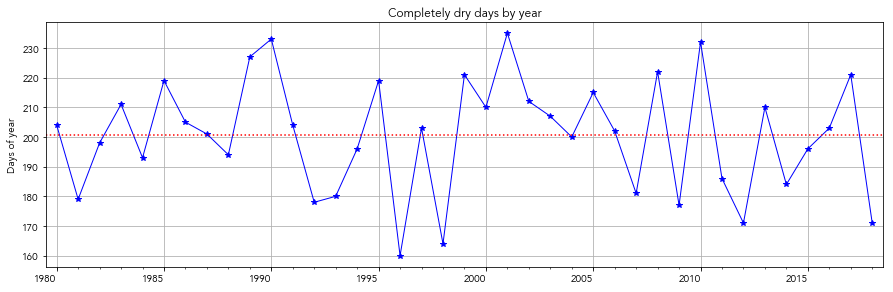

In [32]:
make_plot(daily_rain_whole_years[np.where(daily_rain_whole_years.values < 0.00001)].groupby('time.year').count(),dataset,'Completely dry days by year',ylabel = 'Days of year',compare_line = daily_rain_whole_years[np.where(daily_rain_whole_years.values < 0.00001)].groupby('time.year').count().mean(),locator = [5,1])

There has been floods in Tehran last week. So, in addition to historical analysis data let's look into precipitation observations as well and find out how many millimeters of rain there has been during flooding. For that, we are using __[NOAA RBSN observation dataset](https://data.planetos.com/datasets/noaa_rbsn_timeseries)__. We choose a station in Tehran (you can find all the stations from the __[RBSN detail page](https://data.planetos.com/datasets/noaa_rbsn_timeseries)__). 

In [33]:
dataset1 = 'noaa_rbsn_timeseries'
station = '40754' #
time_start_synop = '2019-01-01T00:00:00'
time_end = datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%dT%H:%M:%S')
variable = 'precipitation_6_hour_accumulation'
link = 'https://api.planetos.com/v1/datasets/noaa_rbsn_timeseries/stations/{0}?origin=dataset-details&apikey={1}&count=1000&time_start={2}&time_end={3}&var={4},lat,lon'.format(station,API_key,time_start_synop,time_end,variable)
synop_data = read_data_to_json(link)
time_synop = [datetime.datetime.strptime(n['axes']['time'],'%Y-%m-%dT%H:%M:%S') for n in synop_data['entries'] if n['data']['precipitation_6_hour_accumulation'] != None]
prec_synop = [n['data']['precipitation_6_hour_accumulation'] for n in synop_data['entries'] if n['data']['precipitation_6_hour_accumulation'] != None]

Here, we make pandas dataframe with observation data as it's easier to do analysis in pandas. 

In [34]:
d = {'time':time_synop,'precipitation_6hr_accu':prec_synop}
df = pd.DataFrame(data = d)
df = df.set_index('time')

In [35]:
jan_feb_mar_daily_mean_prec = np.mean(daily_rain_whole_years.loc[daily_rain_whole_years['time.month'] < 4])

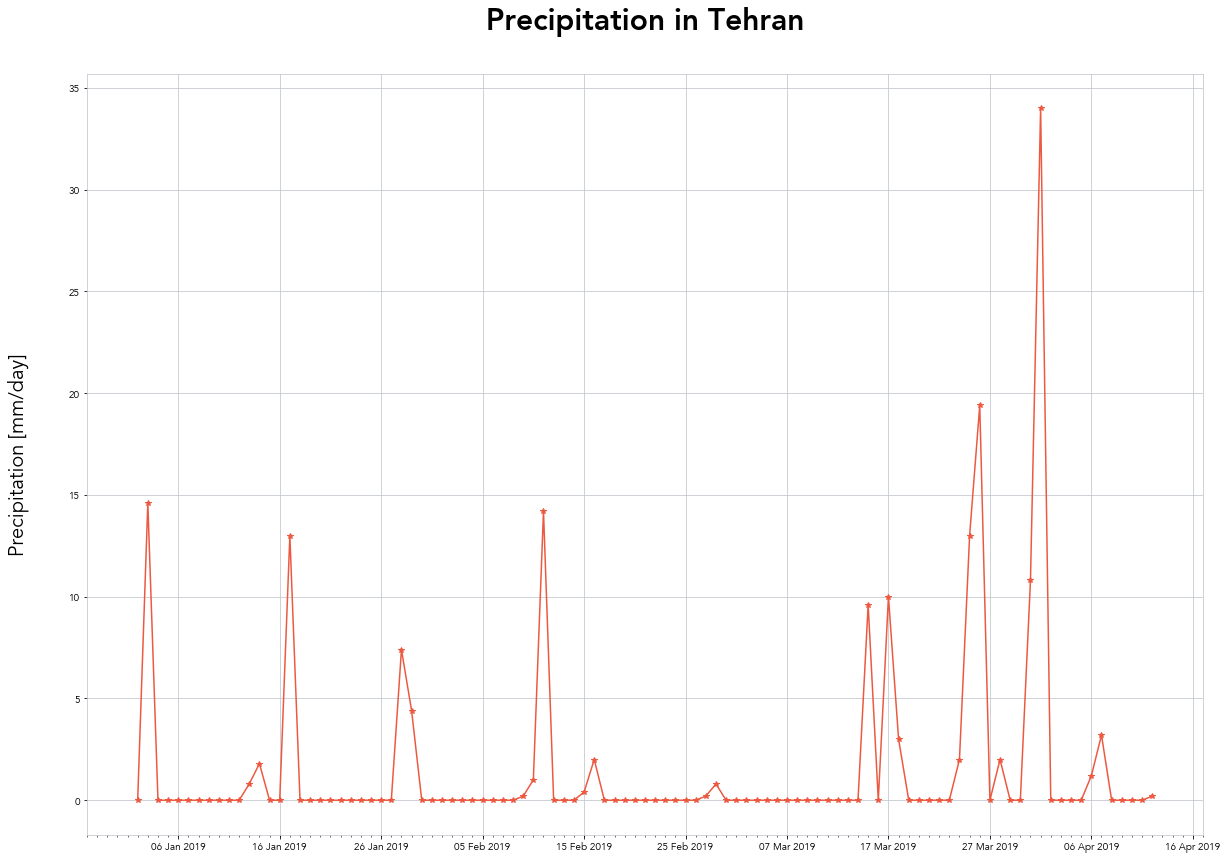

Usual daily precipitation is 0.4 mm/day during the period
Maximum amount of precipitation during the period was 34.0 mm/day


In [36]:
make_monthly_plot(df.resample('1D').sum(),df.resample('1D').sum().index,'Precipitation [mm/day]','Precipitation in Tehran',locator=[10,1])
print ('Usual daily precipitation is ' + str("%.1f" % jan_feb_mar_daily_mean_prec) + ' mm/day during the period')
print ('Maximum amount of precipitation during the period was ' + str("%.1f" % np.max(df.resample('1D').sum().values)) + ' mm/day')

We definiately know that in the end of March, there were __[devastating floods in Tehran](https://en.radiofarda.com/a/flooding-in-tehran-as-death-toll-climbs-and-more-severe-rain-expected-in-iran/29843719.html )__. We can see from observation data that there were the most precipitation on 26th of March, when  precipitation amount was 19.4 mm/day. As we can see, average daily precipitation amount is only 0.4 mm/day, but once in a while it exceeds even 5 mm/day. Below we can see how often daily precipitation in Tehran exceeds 5 mm/day threshold (since 1980). However, 5 mm/day isn't dangerous, but more than one day precipitation in a row in dry area like Iran, can get flooding easily.

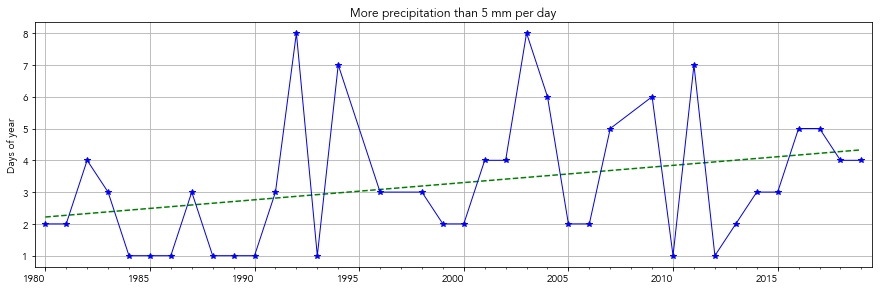

In [37]:
make_plot(daily_rain[np.where(daily_rain.values > 5)].groupby('time.year').count(),dataset,'More precipitation than 5 mm per day',ylabel = 'Days of year',trend=True,locator = [5,1])

Finally,we let's see an annual precipitation cycle as well. This way we can get and overview how rainy different months can be. We can see that montly it rains in March and April. Summer moths tend to be almost totally dry. Also, we can see that Tehran has pretty dry climate as daily average precipitation is always below one. 

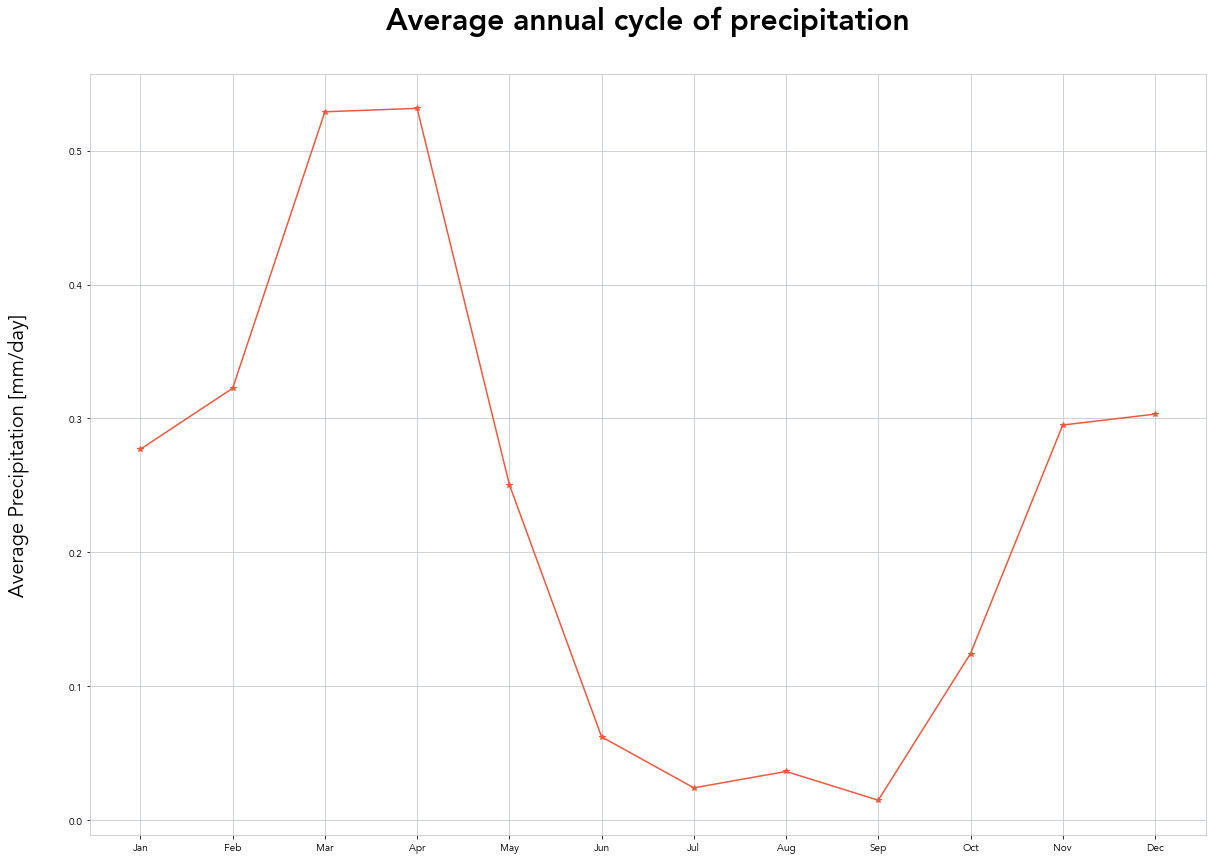

In [38]:
make_monthly_plot(daily_rain_whole_years.groupby('time.month').mean(),[calendar.month_abbr[m.values] for m in daily_rain_whole_years.groupby('time.month').mean().month],'Average Precipitation [mm/day]', 'Average annual cycle of precipitation')

In conclusion, climate changes in Tehran are a bit worrying as temperature has rising trend. We can also see a rising trend in annual precipitation, however, some parts of Iran tend to have decreasing trend. Tehran has very dry climate and this is the reason why heavy rains can cause flooding easily. 